In [6]:
#disable warnings
import warnings
warnings.filterwarnings("ignore") 

# Purpose of this Notebook

In [7]:
#Number of reviews to put into data frame of good reviews. Set it to less than 0 if you want all of the good reviews to be processed
NUMB_OF_GOOD_REVIEWS = -1

#Number of reviews to put into data frame of bad reviews
NUMB_OF_BAD_REVIEWS = -1

#set to 1 if you want to reclean the dataframes, otherwise it will load data from a previous clean
#note cleaning takes 30 minutes on a pretty fast machine
CLEAN_DATAFRAME = 0

#used to seed the random state in parts of the NLP pipeline that need it
RANDOM_STATE=42

#the max number of processors to use in parallel for performing certain text processing steps in the NLP pipeline
N_JOBS = 8


#number of topics to generate in the document-term matrix created via LDA
NUMBER_OF_TOPICS=20

#Set to 1 if you want to generate scatter plots of the entire set of bad and good reviews (1 plot for the bad reviews, 1 plot for the good reviews). 
#WARNING this will take about 12 hours to generate
GENERATE_FULL_SCATTER_PLOT = 0

## Problem Statement

Product developers often want to know this about their products:

* For products that people don't like, what is it about the products they don't like? Maybe if we know this we could improve the product by fixing this unliked product features
* For products that people love, what is it about the products that result in people loving them? Maybe if we expanded on these loved features, we could get new customers or better retain current customers

## Proposed Solution

Perform [topic modeling ](https://en.wikipedia.org/wiki/Topic_model) that helps product managers identify the features of products that people love so that a product manager can have an idea of things that could be addressed to get more "likes" for the product.

Perform topic modeling that helps product managers pinpoint features of products that people don't like so that a product manager can determine what could be fixed to hopefully turn the disliked product into a liked product.


# Module Import

In [8]:
import datetime
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

#to speed up pandas operands
from pandarallel import pandarallel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#code to perform tSNE plots
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Import seaborn and matplotlib.patheffects to make nice plots.
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

#gensim
from gensim import corpora, models, similarities, matutils



In [9]:
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'png'
%matplotlib inline 

# NLP Pipeline

This section of the notebook steps through the various stages of text processing starting with initial raw text read in from the CSV file and ends with the TFIDF-vectorized document-term matrix.


## Text Preprocessing

This diagram describes what is happening in the early parts of the document processing pipeline:

![text_preproc](./../Documents/Images/text_preprocessing.jpg)

**Deduplication**: Removed any rows in the original CSV that are duplicates. See code below for more on how duplicates were chosen.

**NaN Removal**: Removed any row in the original CSV that contained one or more `NaN` (not a number) entries or where `HelpfulnessDenominator==0`.

**Cleaning**: Removed HTML and non-English words (according to NLTK's dictionary), removed punctuation, removed numbers, or space-delimited strings that contain numbers, converted what remains to lowercase

**Tokenization**: Converted the review, which exists as a single string, into separate strings, one string per word as identified by NLTK's `word_tokenize()`

**Lemmatization**: Convert each word into its equivalent form found in the dictionary using NLTK's `WordNetLemmatizer()`

Rationale for all of this processing: To reduce the impact of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), and to not steer subsequent analysis steps to operate on misspelled words.

For example the word "buying" and "bought" both appear in the review corpus. Both of these words are variations of the dictionary term "buy" and hence mean the same thing. If we were to allow all three terms to be analyzed it woud result in a matrix, where each document would be defined by three extra vector components when just one would suffice. Adding these extra terms increases the sparsity of the resultant document-term matrix which makes it harder given the fixed data set.

The downside of this processing is that there are meaningful terms, that because they do not exist in the dictionary, are removed. For example the term [zubaz](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is removed from the corpus. This and other similar terms could be added back by manually expanding the set of terms in the NLTK dictionary, given more engineering time.


In [10]:
reviews_df = pd.read_csv("../Data/Reviews.csv")



In [11]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
reviews_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


According to the [Kaggle description](https://www.kaggle.com/snap/amazon-fine-food-reviews) of the dataset `HelpfulnessNumerator` should be less than or equal to `HelpfulnessDenominator`. So I will filter out any reviews that do not meet this specification.  Also, removing reviews where `HelpfulnessDenominator` is zero as this indicates a review that is not useful:

In [13]:
#reviews that don't satify the filter-out specification and are thus, valid
mask = (reviews_df["HelpfulnessNumerator"] <=  reviews_df["HelpfulnessDenominator"]) & (reviews_df["HelpfulnessDenominator"] > 0)
reviews_df[~mask].shape

(270054, 10)

There are few to remove so doing that now:

In [14]:
reviews_df = reviews_df[mask]

**Deduplication**: Are there any duplicate entries?

In [15]:
reviews_df.duplicated(subset=["UserId","ProfileName","Time","Text"],keep="first").value_counts()

False    209681
True      88719
dtype: int64

In [16]:
reviews_df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"],keep="first",inplace=True)

**NaN Removal**

In [17]:
reviews_df.dropna(inplace=True)

Speculative EDA: calculating a helpfulness metric in the hopes that it helps separate reviews.

In [18]:
reviews_df["helpful_rating"] = reviews_df["HelpfulnessNumerator"] / reviews_df["HelpfulnessDenominator"]

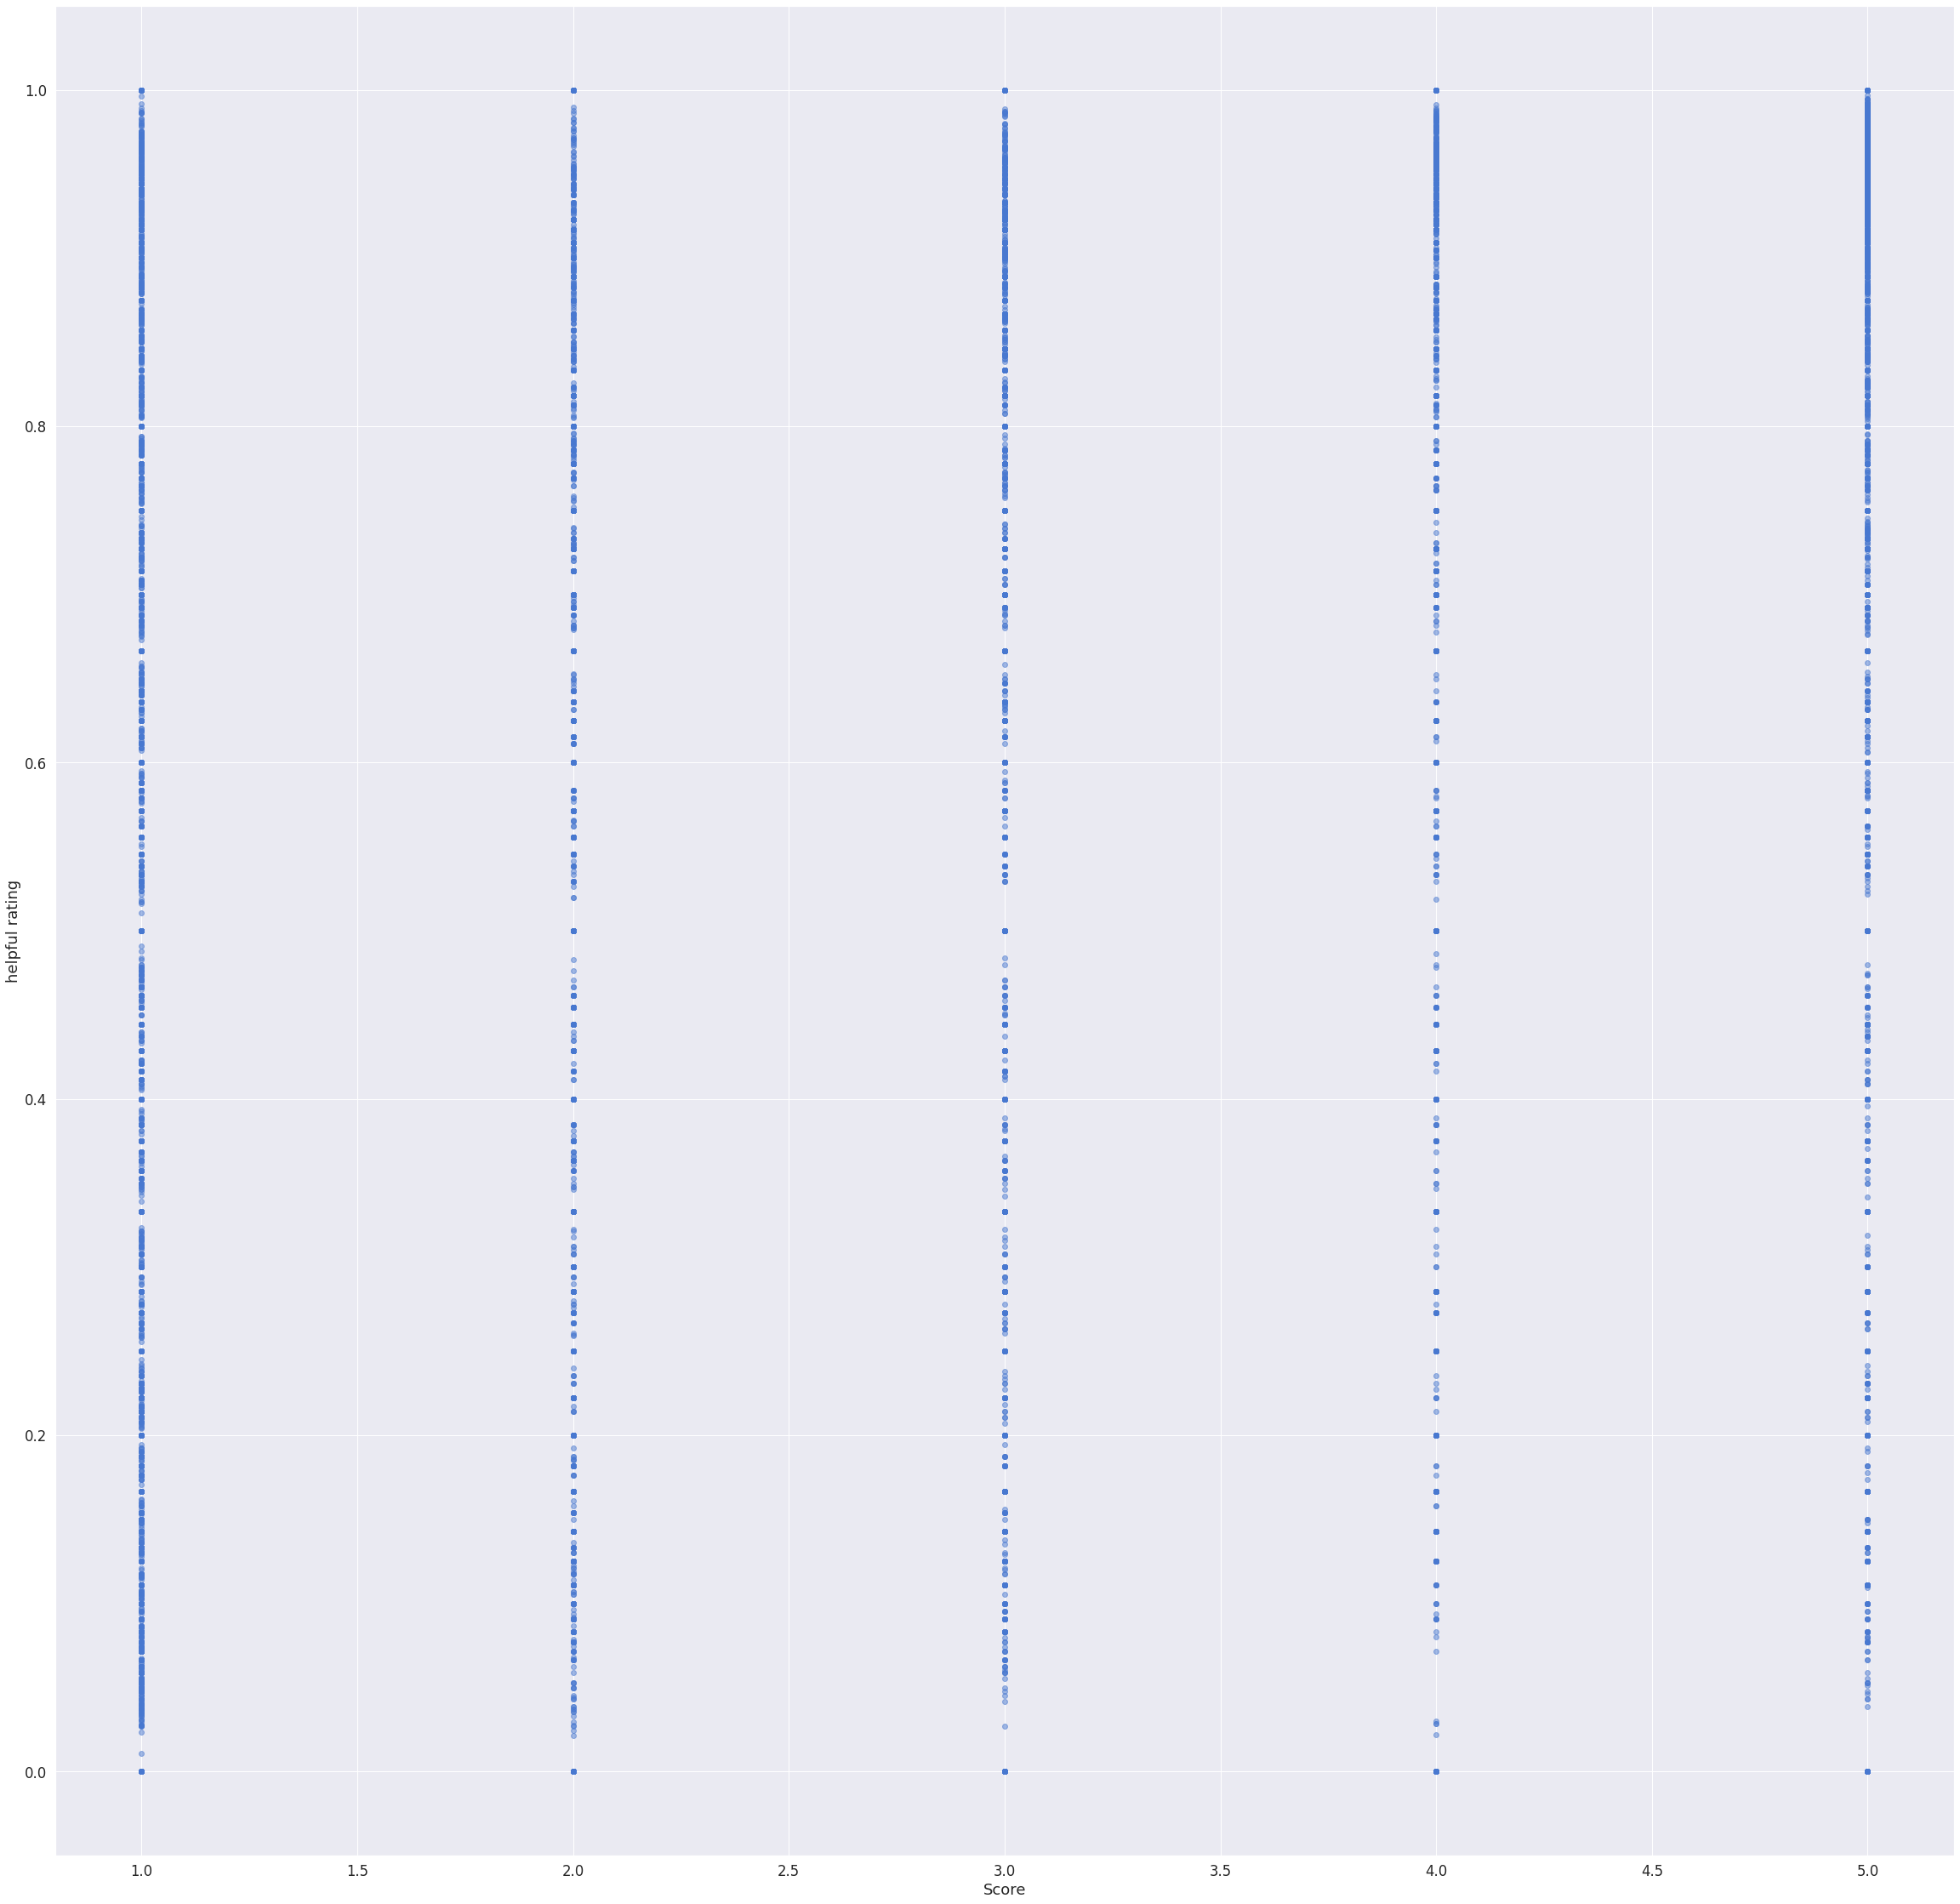

In [19]:
plt.figure(figsize=(40,40))
plt.scatter(reviews_df["Score"],reviews_df["helpful_rating"],alpha=0.5)
plt.xlabel("Score")
plt.ylabel("helpful rating")
plt.show();

This small bit of EDA does not yield any useful separation of reviews. Will not pursue anymore EDA for now.

Going to create a dataframe of bad reviews and one of good reviews to process separately. I remove reviews where "Score" == 3 because these do not indicate a call to action to either improve a bad product or point out a product that likely has nice features.



In [20]:
good_reviews_df = reviews_df[ reviews_df["Score"] >= 4 ]
bad_reviews_df = reviews_df[ reviews_df["Score"] <= 2 ]

In [21]:
if (NUMB_OF_GOOD_REVIEWS > good_reviews_df.shape[0]) or (NUMB_OF_GOOD_REVIEWS < 0):
    NUMB_OF_GOOD_REVIEWS = good_reviews_df.shape[0]


if (NUMB_OF_BAD_REVIEWS > bad_reviews_df.shape[0]) or (NUMB_OF_BAD_REVIEWS < 0):
    NUMB_OF_BAD_REVIEWS = bad_reviews_df.shape[0]

In [22]:
good_reviews_df = good_reviews_df[:(NUMB_OF_GOOD_REVIEWS + 1)]
bad_reviews_df = bad_reviews_df[:(NUMB_OF_BAD_REVIEWS + 1)]

This is the function used to perform the **Cleaning** step described above.

In [23]:
#Removing HTML from the text
#stuff = [re.sub("<.*?>","",item) for item in stuff]

def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["Text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process



In [24]:
if CLEAN_DATAFRAME == 1:

    #TODO If you have time - convert it to a SQL query
    pandarallel.initialize()

    start_time = datetime.datetime.now()

    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(remove_html_punct,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(remove_html_punct,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
else:
    print("skipping cleaning the data frame.")

skipping cleaning the data frame.


It takes a long time to perform this operation so going to save it to a pickle file if I ever need to rerun but don't need to do this cleaning step.

In [25]:
if CLEAN_DATAFRAME == 1:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)
    

In [26]:
good_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating,ProcessedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,i have bought several of the vitality canned d...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,this is a confection that been around a few it...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,right now mostly just sprouting this so my can...
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,i know if the or the tequila or just the uniqu...
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,one of my to lose some weight and the other i ...


In [27]:
bad_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating,ProcessedText
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,if you are looking for the secret ingredient i...
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,1.0,my have been happily eating platinum for more ...
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0.0,the candy is just red no flavor just plan and ...
50,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,1,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",0.0,this oatmeal is not good its mushy soft i like...
62,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,1,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,1.0,in days and were so stale i could not eat any ...


In [28]:
good_reviews_df.reset_index(inplace=True)

Demonstrating here what the original review `Text` looks like compared to the `ProcessedText` at this point.

In [29]:
good_reviews_df.loc[0,"Text"]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [30]:
good_reviews_df.loc[0,"ProcessedText"]

'i have bought several of the vitality canned dog food and have found them all to be of good quality the product more like a stew than a meat and it better my is and she this product better than most'

In [31]:
bad_reviews_df.reset_index(inplace=True)

In [32]:
bad_reviews_df.loc[0,"Text"]

'If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.'

In [33]:
bad_reviews_df.loc[0,"ProcessedText"]

'if you are looking for the secret ingredient in i believe i have found it i got this in addition to the root beer extract i ordered which was good and made some cherry soda the flavor is very medicinal'

**Tokenization**

In [34]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["ProcessedText"])
    return temp_tokenized_txt


In [35]:
pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(tokenize_text,axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(tokenize_text,axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:15.740228


Here's what reviews look like after tokenization:

In [36]:
good_reviews_df.loc[0,"ProcessedText"]

['i',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'vitality',
 'canned',
 'dog',
 'food',
 'and',
 'have',
 'found',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'meat',
 'and',
 'it',
 'better',
 'my',
 'is',
 'and',
 'she',
 'this',
 'product',
 'better',
 'than',
 'most']

In [37]:
bad_reviews_df.loc[0,"ProcessedText"]

['if',
 'you',
 'are',
 'looking',
 'for',
 'the',
 'secret',
 'ingredient',
 'in',
 'i',
 'believe',
 'i',
 'have',
 'found',
 'it',
 'i',
 'got',
 'this',
 'in',
 'addition',
 'to',
 'the',
 'root',
 'beer',
 'extract',
 'i',
 'ordered',
 'which',
 'was',
 'good',
 'and',
 'made',
 'some',
 'cherry',
 'soda',
 'the',
 'flavor',
 'is',
 'very',
 'medicinal']

**Lemmatization**

In [38]:
wordNetLemmatizer = WordNetLemmatizer()

In [39]:
#lemmatize each word in stuff
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos




In [40]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["ProcessedText"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


Lemmatization takes a while (~10min) on my desktop. To save time I will save it off and only regenerate when I need to:

In [41]:
if CLEAN_DATAFRAME == 1:
    
    pandarallel.initialize()
    start_time = datetime.datetime.now()
    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lemmatize_it,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lemmatize_it,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews_lemmatized.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews_lemmatized.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews_lemmatized.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews_lemmatized.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)

Lemmatization cuts down on the size of the dimensions of the eventual vectorized word matrix without losing meaning of the text.

In [42]:
good_reviews_df.loc[0,"ProcessedText"] 

'i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most'

In [43]:
bad_reviews_df.loc[0,"ProcessedText"] 

'if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal'

**Note**: In an earlier version of this notebook, I thought the analysis would be improved by only including the adjectives from the reviews in the downstream NLP pipeline. After looking through the resultant topic modeling, I realized it would be better to include the entire post-processed review into the pipeline. As it turns out the resultant topic-modeling yielded better results, i.e. the topics were more meaningful and were more easily related to the constituent reviews.

I leave the cell below to show how I went about removing the adjectives:

In [44]:
# I only want adjectives and adverbs sent to the vectorizer

def filter_pos(row,pos_abbrev=["JJ"]):
    """
    takes as input the following
    processes the "ProcessedText" column of a review data frame (see definition above)
    pos_abbrev = list of NLTK pos_tag() output parts of speech codes abbreviated to the first two characters
    
    """
#    print("pos_abbrev = ",pos_abbrev)

    
    if type(pos_abbrev) != type([]):
        print("post_abbrev must be a list of POS codes (1st 2 characters of the code only)")
        return 1
    
    temp_pos_filtered_doc = ""
    
    #pos_tag() works better if you pass the entire document to it as a tokenized list
    #it must be doing some sequence modeling under the hood to get the context of words so that it can
    #better ID parts of speech
        
    pos_result = pos_tag(row["ProcessedText"])
    
    for result_word, result_pos in pos_result:
        #print("tokenized word = ", word_tokenize(mylemword))
        #print("tokenized word pos = ", pos_tag(word_tokenize(mylemword))[0][1])
        
        for mypos in pos_abbrev:
            if (mypos in result_pos) :
                temp_pos_filtered_doc = temp_pos_filtered_doc + result_word + " "
            
    
    return temp_pos_filtered_doc.rstrip()


**TODO**: Run the notebook through with everything turned on as your final copy of the notebook.

Now just running `join()` on the tokenized reviews.

In [45]:
#stuff_pos_filtered = filter_pos(stuff_lemmatized,pos_abbrev=["JJ","RB"])
#stuff_pos_filtered
#stuff_pos_filtered = stuff_pos_filtered + filter_pos(stuff_lemmatized,"RB")

#Not doing this to see how LDA works when it's given all of the words of  each reive.
#pandarallel.initialize()
#start_time = datetime.datetime.now()
#good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(filter_pos,axis=1,pos_abbrev=["JJ","RB"])
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))

#pandarallel.initialize()
#start_time = datetime.datetime.now()
#good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
#bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))



These cells were here to demonstrate the final review with only adjectives in it.

In [46]:
#good_reviews_df.loc[0,"ProcessedText"]

In [47]:
#bad_reviews_df.loc[0,"ProcessedText"]

Final shape of bad and good reviews dataframes

In [48]:
good_reviews_df.shape

(152586, 13)

In [49]:
bad_reviews_df.shape

(40420, 13)

## Review Vectorization

Will do the following here:
![tfidf_vectorize](../Documents/Images/tfidf_vectorization.jpg)

I did document vectorization (i.e. converting each document into a vector, where each component of the vector is a number that represents some feature of the document) using `CountVectorizer` and `TfidfVectorizer`. I settled on `TfidfVectorizer` because it resulted in topics that made slightly better sense.


_Why I selected TFIDF?_

The are a few words that are used very frequently in the corpus, like "buy":

```shell
(metis_linux_venv) :> grep -i buy Reviews.csv|wc -l
95872
(metis_linux_venv) :> grep -i bought Reviews.csv|wc -l
46267

```

Using `CountVectorizer` the documents' vectors would weigh heavily in the direction of frequent terms, which could then lead to this being a topic. Given that this corpus' overarching theme is about products purchased on Amazon, giving it such weight doesn't seem warranted and does not add useful information beyond a certain point.

The TFIDF calculates the magnitude of the vector components for each word in the document according to this equation:

`TFIDF = (TermCountInDocument)/(TotalDocumentTerms) * log(TotalDocuments/DocumentsContainingTerm)`

So in count vectorized document-term matrix the word "buy" has much more influence on the topic assignment of a document than in the TFIDF vectorized document matrix. Here's an example:

Below is the "buy" vector component magnitude in the count vectorized document-term matrix for a few documents:

![count_vect_example](../Documents/Images/count_matrix_example.png)

Here's the "buy" vector component values for the same documents in the TFIDF vectorized document-term matrix:

![tfidf_vect_example](../Documents/Images/tfidf_matrix_example.png)

As you can see the vector component magnitudes for "buy" in the latter example are smaller because they are found in a large number of documents.

The word "mold," which only shows up in 1541 documents, yet is a pretty significant topic in human terms, now will have a correspondingly weighted mathematical significance (TFIDF shown below):
![tfidf_vect_example2](../Documents/Images/tfidf_matrix_example2.png)


In [50]:
#Commenting out results based on count vectorization based on the explanation above and to save processing time
#vectorizer_gr = CountVectorizer(stop_words="english")
#docTermMatrixCountVecGR = vectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])

tfidfvectorizer_gr = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFGR = tfidfvectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])


In [51]:
#vectorizer_br = CountVectorizer(stop_words="english")
#docTermMatrixCountVecBR = vectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

tfidfvectorizer_br = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFBR = tfidfvectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

In [52]:
#len(vectorizer_gr.get_feature_names())

Checking dimenstions here. Did this to notice how much curse of dimensionality I would have to deal with. In an earlier version of this notebook printing this out was important in detecting a need for further upstream processing so leaving it in here.


In [53]:
docTermMatrixTFIDFBR.shape

(40420, 15183)

In [54]:
docTermMatrixTFIDFGR.shape

(152586, 21926)

In [55]:
#len(vectorizer_br.get_feature_names())

In [56]:
#docTermMatrixCountVecGR.toarray()

In [57]:
#docTermMatrixCountVecGR.shape

In [58]:
#docTermMatrixCountVecBR.toarray()

In [59]:
#docTermMatrixCountVecBR.shape

Creating this dataframe to create a human-readable depiction of the document term matrix

In [60]:
docTermMatrixTFIDFGR_df = pd.DataFrame(
    docTermMatrixTFIDFGR.toarray(),
    index=good_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_gr.get_feature_names()
)

In [61]:
#commented out but left in. It is used for illustration purposes and takes a while to run
#docTermMatrixTFIDFGR_df.loc[docTermMatrixTFIDFGR_df["mold"]>0,["mold"]].head(5)

In [62]:
#docTermMatrixTFIDFGR_df.head(3)

In [63]:

#docTermMatrixCountVecGR_df = pd.DataFrame(docTermMatrixCountVecGR.toarray(), index=good_reviews_df["ProcessedText"], columns=vectorizer_gr.get_feature_names())

In [64]:
#docTermMatrixCountVecGR_df.head(2)

In [65]:
#commented out but left in. It is used for illustration purposes and takes a while to run
#docTermMatrixCountVecGR_df.loc[docTermMatrixCountVecGR_df["mold"]>0,["mold"]].head(5)

In [66]:
docTermMatrixTFIDFBR_df = pd.DataFrame(
    docTermMatrixTFIDFBR.toarray(),
    index=bad_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_br.get_feature_names()
)

In [67]:
docTermMatrixTFIDFBR_df.head(3)

,aa,aback,abalone,abandon,abandoned,abandonment,abbey,abdomen,abdominal,aberrant,...,zipper,zippy,zombie,zone,zoo,zoology,zoom,zoonotic,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
my have be happily eat platinum for more than two i just get a new bag and the shape of the food be different they try the new food when i first put it in their bowl and now the bowl sit full and the will not touch the food similar relate to formula in the past unfortunately i now need to find a new food that my will eat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the candy be just red no flavor just plan and chewy i would never buy them again,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
#docTermMatrixCountVecGR_df.columns

In [69]:
#docTermMatrixCountVecBR_df.columns

# Analysis of Reviews

We are moving on to the analysis portion of this project. Per the original goal, we want to provide specific information to product developers: We want to let them know specific information regarding products that received good reviews, and specific information about products that received bad reviews.

One way to provide specific information is to extract the topics (i.e. abstract ideas that represent the contents of the underlying text) from both the set of good reviews and bad reviews.

One way to extract these topics is to perform [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the document-term matrices generated above in the previous section.

LDA works because documents have the following properties:

* All documents are collections of words where each word has a definite meaning
* A document's overall meanning if a function of the words used within it

Performing certain mathematical operations based on these ideas enables uncovering semantics that exist within the document but are not explicitly stated within the document (hence they are latent). We can use this latent information within the reviews (the topics) to quickly zero in what could be driving bad reviews or good reviews.

## Topics Generation Via LDA

In this section I perform LDA to generate a document-topic matrix for the corpus of good reviews. Each row of this matrix represents one of the reviews. Each column represents the degree to which the document belongs to the topic corresponding to that column:

```       
                     Topic0   Topic1   Topic2 ... TopicN-1
                      
Rows 0 (Review 0)     0.1     0.001    0.002      0.0018 


```

In the text above I show a single row (which represents a single review). Each number represents to what extent this review belongs to the varous topics (N different topics) generated by the LDA calculation.

In [70]:
#LD_AllocatorGR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
#LD_AllocatorBR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
LD_AllocatorTFIDFGR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
LD_AllocatorTFIDFBR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)


In [71]:
#start_time = datetime.datetime.now()
#LD_AllocatorGR.fit(docTermMatrixCountVecGR)
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))

In [72]:
#start_time = datetime.datetime.now()
#LD_AllocatorBR.fit(docTermMatrixCountVecBR)
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))

In [73]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFGR.fit(docTermMatrixTFIDFGR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:01:22.120744


In [74]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFBR.fit(docTermMatrixTFIDFBR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:00:14.663504


## Visualization of Reviews

### LDA Visualizations

#### Good Reveiws

In [75]:
#This module has an adverse affect on the Jupyter lab interface. So I comment it out most of the time. It's why importing down here--for convience.
import pyLDAvis
import pyLDAvis.sklearn

In [76]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(LD_AllocatorTFIDFGR, docTermMatrixTFIDFGR, tfidfvectorizer_gr)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.054176 -0.048548       1        1  9.111895
17    -0.069501 -0.037767       2        1  9.085696
1      0.109953 -0.049147       3        1  7.840493
13    -0.109366  0.005414       4        1  7.163846
5     -0.006800  0.072950       5        1  7.069756
11    -0.065769 -0.051750       6        1  6.750988
15    -0.066006  0.042267       7        1  6.670138
7     -0.059334 -0.035433       8        1  6.217156
14    -0.043998  0.046431       9        1  5.039927
12    -0.010554  0.073737      10        1  4.001125
18    -0.015594 -0.061460      11        1  3.849175
19    -0.035264 -0.039189      12        1  3.830729
10    -0.002358  0.121719      13        1  3.502745
6      0.086073  0.087968      14        1  3.289874
16    -0.026918 -0.081109      15        1  3.169684
4      0.129109 -0.101384      16        1  3.156323
3      0.081340 -0.037865      17        1  3.118667
8      0.140213 -0.013437      18        1  2.931508
9     -0.039403 -0.013979      19        1  2.261097
2      0.058354  0.120582      20        1  1.939178, topic_info=         Term         Freq        Total Category  logprob  loglift
3459   coffee  3722.000000  3722.000000  Default  30.0000  30.0000
19052     tea  3763.000000  3763.000000  Default  29.0000  29.0000
5538      dog  2111.000000  2111.000000  Default  28.0000  28.0000
3128     chip   949.000000   949.000000  Default  27.0000  27.0000
12797     oil  1268.000000  1268.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
14539   price    38.394085  2638.340253  Topic20  -5.7407  -0.2871
11144    make    38.302868  3322.233501  Topic20  -5.7431  -0.5200
1682     best    36.373334  2824.344137  Topic20  -5.7948  -0.4093
7460    fresh    34.744958  1340.143463  Topic20  -5.8406   0.2904
20844     use    34.190773  3670.537410  Topic20  -5.8567  -0.7332

[1605 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
0         12  0.862114      aa
21         1  0.054708    able
21         2  0.053406    able
21         3  0.074247    able
21         4  0.039077    able
...      ...       ...     ...
21907      2  0.102941    zinc
21907     15  0.720584    zinc
21907     16  0.154411    zinc
21917      5  0.838585  zombie
21919      2  0.862283     zoo

[8795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 2, 14, 6, 12, 16, 8, 15, 13, 19, 20, 11, 7, 17, 5, 4, 9, 10, 3])

#### Bad Reveiws

In [77]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(LD_AllocatorTFIDFBR, docTermMatrixTFIDFBR, tfidfvectorizer_br)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.181450  0.004770       1        1  15.790633
6     -0.166592  0.045970       2        1  15.622662
10    -0.135810  0.037082       3        1  11.792507
7     -0.197943 -0.109075       4        1  11.687616
2     -0.136061  0.089850       5        1   7.294247
8     -0.112372  0.072909       6        1   7.026344
18    -0.131590 -0.038456       7        1   5.567429
17    -0.084911 -0.124047       8        1   3.342851
11    -0.050513  0.044424       9        1   2.761356
13    -0.003501  0.050485      10        1   2.491028
5      0.024216 -0.064695      11        1   2.106805
1      0.005378 -0.122030      12        1   1.929718
12     0.092713  0.085292      13        1   1.793240
9      0.053910  0.042456      14        1   1.780406
3      0.131687  0.077216      15        1   1.717905
16     0.081918 -0.012792      16        1   1.614675
14     0.175755 -0.003860      17        1   1.541863
19     0.183215  0.003287      18        1   1.435809
4      0.225653 -0.040342      19        1   1.373072
0      0.226297 -0.038445      20        1   1.329836, topic_info=          Term        Freq       Total Category  logprob  loglift
2348    coffee  878.000000  878.000000  Default  30.0000  30.0000
3877       dog  578.000000  578.000000  Default  29.0000  29.0000
13185      tea  673.000000  673.000000  Default  28.0000  28.0000
2066    cheese  197.000000  197.000000  Default  27.0000  27.0000
13073    syrup  187.000000  187.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
9016   ordered    4.171864   17.859664  Topic20  -6.2492   2.8659
4683       eye    3.948655   14.989145  Topic20  -6.3042   2.9862
14800  weekend    3.823025   14.225817  Topic20  -6.3366   3.0061
11443     scam    3.787322   15.786711  Topic20  -6.3460   2.8926
11409    sauce    3.759568  217.393954  Topic20  -6.3533   0.2627

[1336 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
0         19  0.760667        aa
54         9  0.076713    absurd
54        12  0.076713    absurd
54        16  0.076713    absurd
54        18  0.690419    absurd
...      ...       ...       ...
15153      9  0.024260      yuck
15153     10  0.012130      yuck
15157     13  0.604085     zante
15165     11  0.635035      zest
15181     14  0.723347  zucchini

[5007 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 7, 11, 8, 3, 9, 19, 18, 12, 14, 6, 2, 13, 10, 4, 17, 15, 20, 5, 1])

In [78]:
#Used for debug: It prints the no_top_words that below to the topics generated by a sklearn LDA object
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
#just here to help debug results
display_topics(LD_AllocatorTFIDFGR, tfidfvectorizer_gr.get_feature_names(),5)


Topic  0
sauce, chicken, use, add, hot

Topic  1
dog, food, cat, eat, love

Topic  2
wrap, salmon, individually, buy, good

Topic  3
work, tea, sleep, trap, day

Topic  4
hair, skin, use, product, oil

Topic  5
price, product, order, great, good

Topic  6
plant, great, candy, buy, tree

Topic  7
drink, water, taste, tea, like

Topic  8
cat, food, baby, litter, eat

Topic  9
chip, vanilla, potato, vinegar, extract

Topic  10
gift, cheese, send, buy, order

Topic  11
gluten, bread, make, mix, flour

Topic  12
store, buy, local, carry, grocery

Topic  13
tea, chocolate, flavor, green, drink

Topic  14
candy, chocolate, gum, like, good

Topic  15
coffee, cup, good, roast, flavor

Topic  16
rice, honey, tuna, fat, good

Topic  17
sugar, snack, cereal, eat, good

Topic  18
milk, use, make, water, good

Topic  19
oil, popcorn, salt, coconut, olive


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
#just here to help debug results
display_topics(LD_AllocatorTFIDFBR, tfidfvectorizer_br.get_feature_names(),5)


Topic  0
cheese, mac, kraft, wedding, macaroni

Topic  1
cracker, candy, basket, buy, gift

Topic  2
sugar, taste, like, good, product

Topic  3
dog, food, china, chicken, toxic

Topic  4
trap, catch, fly, moth, beef

Topic  5
plant, soup, grow, crab, product

Topic  6
taste, like, flavor, try, eat

Topic  7
order, price, product, receive, box

Topic  8
coconut, water, product, oil, juice

Topic  9
soy, bacon, product, mustard, kefir

Topic  10
dog, food, eat, cat, product

Topic  11
peanut, butter, cereal, taste, like

Topic  12
syrup, corn, china, fructose, make

Topic  13
gluten, bread, free, flour, wheat

Topic  14
hair, gum, energy, xylitol, shampoo

Topic  15
coffee, tea, taste, like, flavor

Topic  16
ginger, like, gelatin, taste, curry

Topic  17
chocolate, gift, order, box, picture

Topic  18
date, taste, expiration, like, stale

Topic  19
truffle, wasabi, chowder, clam, bee


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### PCA

In this sections I perform principal component analysis: I reduce 20 topics down to 2 principal components and then plot the documents using these components as the x and y coordinates. The purpose is to get a visual representation of the documents, the topics to which they belong, and the document's proximity to other documents of the same or possibly different topic. The result may help prompt other analysis to better understand certain arrangement of docments on the plot. For example if there exists a cluster of documents that all belong to different topics, this may prompt analysis of these documents to determine why they belong to the same cluster yet are assigned to different topics.

#### Good Reviews
First let's check the quality of results of the topic generation by finding the reviews that scored best on a selected topic in the `docTopicMatrixGF_df`

##### Eye-Ball Checking Text

In [81]:
#docTopicMatrixGR = LD_AllocatorGR.transform(docTermMatrixCountVecGR)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
docTopicMatrixGR = LD_AllocatorTFIDFGR.transform(docTermMatrixTFIDFGR)

#LD_AllocatorTFIDFGR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)
#LD_AllocatorTFIDFBR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
docTopicMatrixGR_df = pd.DataFrame(docTopicMatrixGR).add_prefix("topic_")
docTopicMatrixGR_df.shape

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(152586, 20)

In [84]:
docTopicMatrixGR_df[["Summary","ProcessedText","Text","Score"]] = good_reviews_df[["Summary","ProcessedText","Text","Score"]]
docTopicMatrixGR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Summary,ProcessedText,Text,Score
0,0.012708,0.758557,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,...,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,Good Quality Dog Food,i have buy several of the vitality can dog foo...,I have bought several of the Vitality canned d...,5
1,0.061524,0.008879,0.203457,0.008879,0.008879,0.008879,0.177861,0.008879,0.008879,0.008879,...,0.364661,0.008879,0.008879,0.008879,0.059306,0.008879,"""Delight"" says it all",this be a confection that be around a few it b...,This is a confection that has been around a fe...,4
2,0.013927,0.013927,0.013927,0.735385,0.013927,0.013927,0.013927,0.013927,0.013927,0.013927,...,0.013927,0.013927,0.013927,0.013927,0.013927,0.013927,Yay Barley,right now mostly just sprout this so my can ea...,Right now I'm mostly just sprouting this so my...,5
3,0.395856,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.462675,0.007859,0.007859,...,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,The Best Hot Sauce in the World,i know if the or the tequila or just the uniqu...,I don't know if it's the cactus or the tequila...,5
4,0.011442,0.782595,0.011442,0.011442,0.011442,0.011442,0.011442,0.011442,0.011442,0.011442,...,0.011442,0.011442,0.011442,0.011442,0.011442,0.011442,"My cats LOVE this ""diet"" food better than thei...",one of my to lose some weight and the other i ...,One of my boys needed to lose some weight and ...,5


In [ ]:
#find 5 reviews that score highest in topic_7
for review in docTopicMatrixGR_df.sort_values(by="topic_15",ascending=False).head(1)[["Summary","Score","Text"]].values:
    print(review,"\n")

From reading these 5 reviews they all seem to be discussion coffee either as a products that are very closely related to coffee.
So `topic_15` is the **coffee**. (_NOTE_: The topic number for coffee may change from run-to-run of this notebook as LDA is a random process. But the coffee subject is in the corpus of good reviews.

Creating a word-topic matrix which will be used to automatically assign human-readable terms to topics when they are plotted.

In [86]:
good_review_vocab = tfidfvectorizer_gr.get_feature_names()
wordTopicmatrixGR_df = pd.DataFrame(LD_AllocatorTFIDFGR.components_,columns=good_review_vocab).T.add_prefix("topic_")
wordTopicmatrixGR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
aa,0.050000,0.050000,0.050000,0.050000,0.276919,0.05,0.345305,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.510673,0.050000,0.050004,0.05,0.05,0.05,8.577289
aardvark,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.357429,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000
aback,3.004662,0.050888,2.248669,0.050000,0.050000,0.05,0.718394,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.231642,0.050000,0.05,0.05,0.05,0.050000
abandon,0.632616,6.235521,0.050000,0.270744,0.050000,0.05,0.233941,0.826850,0.050000,0.05,0.545215,0.698987,0.05,1.797126,0.050000,0.050000,0.05,0.05,0.05,0.050000
abandoned,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.355548,0.05,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000


##### Cluster Plot

In [87]:
pcaGR = PCA(n_components=2)
pcaGR.fit(docTopicMatrixGR)
docReducedTopicMatrixGR = pcaGR.transform(docTopicMatrixGR)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
pcaGR.components_

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-0.5100368 , -0.05860459, -0.00284095, -0.00397498, -0.00613948,
        -0.06487031, -0.00730354, -0.01621936, -0.00507547, -0.00226395,
        -0.00930723, -0.03084353, -0.01169187, -0.04825919, -0.00936324,
        -0.04364884, -0.00439148,  0.85214145, -0.00823127, -0.00907538],
       [ 0.79323149, -0.27640717, -0.00659659, -0.01511004, -0.0155993 ,
        -0.21458402, -0.01639892, -0.07076507, -0.01626735, -0.00638846,
        -0.02089398, -0.09776554, -0.02036213, -0.17306563, -0.04721938,
        -0.16489537, -0.00964193,  0.41440071, -0.01710565, -0.01856567]])

In [89]:
docReducedTopicMatrixGR.shape

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(152586, 2)

In [90]:
docReducedTopicMatrixGR[0][0],docReducedTopicMatrixGR[0][1]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.05300625176888632, -0.23072656952667767)

In [91]:
#Color map used to color each document in the plot
TOPIC_COLORS={"topic_0":"red",
                 "topic_1":"orange",
                 "topic_2":"yellow",
                 "topic_3":"green",
                 "topic_4":"blue",
                 "topic_5":"indigo",
                 "topic_6":"violet",
                 "topic_7":"cyan",
                 "topic_8":"brown",
                 "topic_9":"white",
                 "topic_10":"gray",
                 "topic_11":"yellowgreen",
                 "topic_12":"skyblue",
                 "topic_13":"chartreuse",
                 "topic_14":"goldenrod",
                 "topic_15":"salmon",
                 "topic_16":"magenta",
                 "topic_17":"cornflowerblue",
                 "topic_18":"ivory",
                 "topic_19":"black"}

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
def getcolor(row_index,basecolor,doc_topic_matrix_df):
    """
    This function takes a document located at `row_index` in the `doc_topic_matrix_df` and determines
    to which topic it belongs by finding the column with the max value at `row_index` in `doc_topic_matrix_df`
    It then uses `TOPIC_COLORS` to return the color associated with that topic
    """
    #assuming the first 20 columns are the topic weights
    global TOPIC_COLORS
    max_topic_name = doc_topic_matrix_df.iloc[:,:20].iloc[row_index].idxmax()
    
    if max_topic_name in TOPIC_COLORS.keys():
        return TOPIC_COLORS[max_topic_name]
    else:
        print("WARNING: Say topic = {} and did not expect to!".format(max_topic_name))
        return "black"
    

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
def plot_PCA_2D2(DocTopic2DMatrix,DocTopicMatrix_df, word_topic_matrix_df, plot_name="pca_scatter_plot.png"):
    """
    Generates a 2-D scatter plot of the reviews.
    
    `DoctTopic2DMatrix` is an array of N documents where the columns in row i represent the (x,y) coordinates for that document (document i)
    
    Each plotted document is colored according to the topic (out of 20) to which it belongs and is
    colored according to the topic-to-color map defined in TOPIC_COLORS
    
    `plot_name`: file name of the plot (must end in png)
    
    """
    #TODO: Get it to work for any number of topics (mostly calc colors using the topic as the offset from a base color)
    global TOPIC_COLORS

    review_names = ["r"+str(numb) for numb in range(len(DocTopic2DMatrix))]
    review_ids = range(len(review_names))
    plotted_topics = []
    plt.figure(figsize=(20,20))
    for id in review_ids:
        color = getcolor(id,"#000000",DocTopicMatrix_df)
        for mykey in TOPIC_COLORS.keys():
            if color == TOPIC_COLORS[mykey]:
                #name = mykey
                #get word best associated with this topic and use that as the label for the point
                name = (word_topic_matrix_df.sort_values(by=mykey,ascending=False).head(1))[mykey].index[0]
        plt.scatter(DocTopic2DMatrix[id][0],DocTopic2DMatrix[id][1],c=color,label=name,edgecolors="gray",alpha=0.8)
        plotted_topics.append(name)
    
    plotted_topics = set(plotted_topics)
    plotted_topics = list(plotted_topics)
    #not needed as I don't use the raw `topic_<X>` monikers anymore
    #plotted_topics.sort(key=lambda x: int(x.split("_")[1]))
    plotted_topics.sort()
    plt.legend(plotted_topics)
    plt.savefig("../Documents/Images/{}".format(plot_name),dpi=400)


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
review_subset_size = 7000

numb_of_good_reviews = docReducedTopicMatrixGR.shape[0]
selected_reviews = np.random.choice(numb_of_good_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixGR_sub = docReducedTopicMatrixGR[selected_reviews,:]


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time spent doing operation is 0:02:51.641064


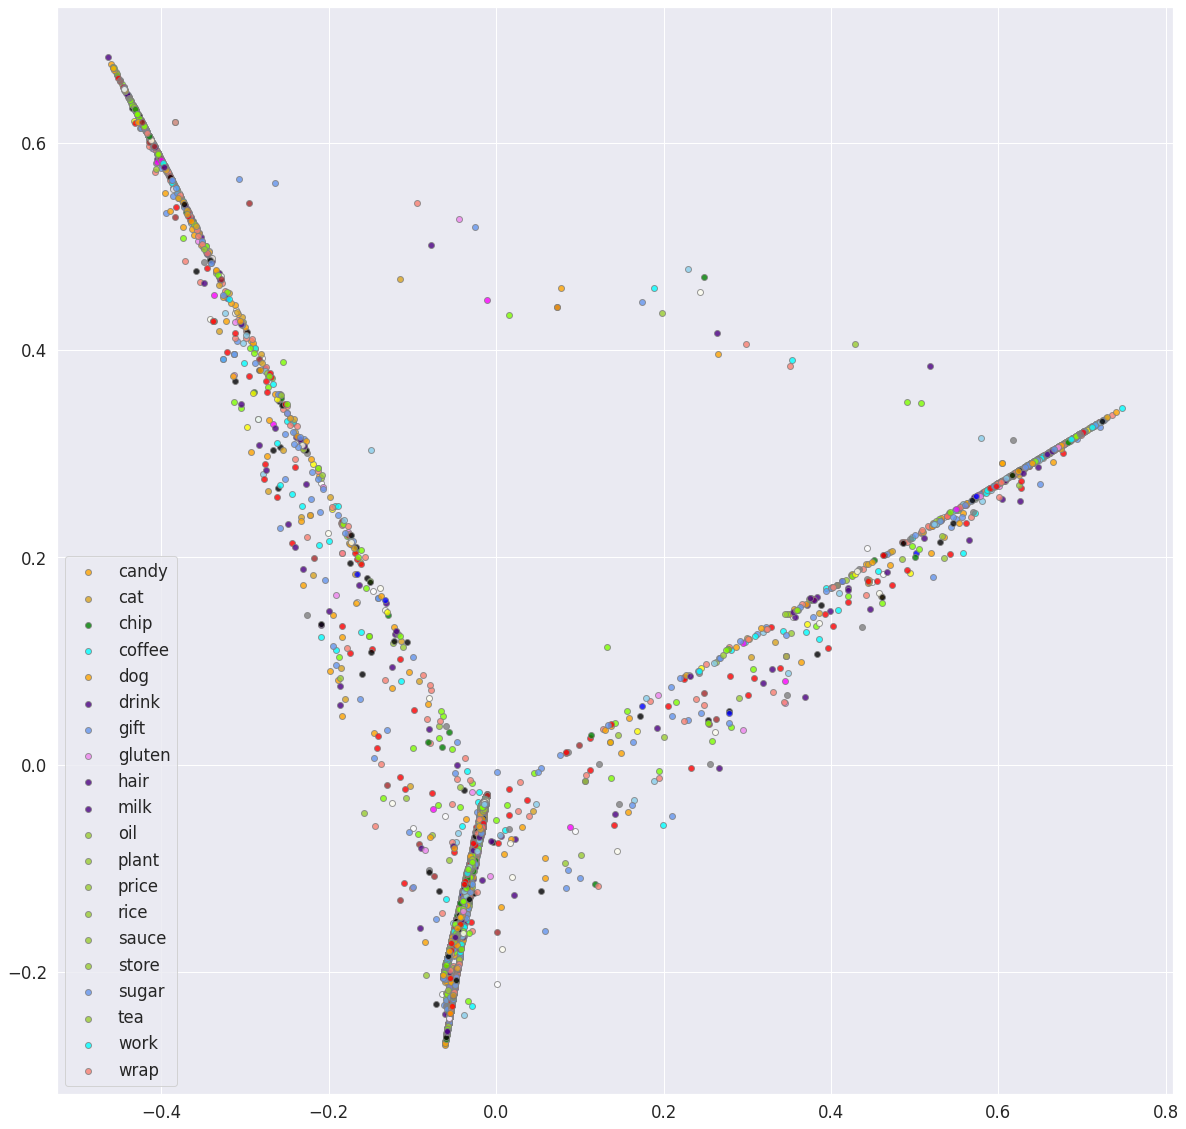

In [95]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()
plot_PCA_2D2(docReducedTopicMatrixGR_sub, docTopicMatrixGR_df, wordTopicmatrixGR_df, "good_reviews_subset.png")
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

This is a plot of 7000 (or whatever `review_subset_size`  is set to ) good review documents. The (x,y) coordinates for each dot (document) comes from `docReducedTopicMatrixGR_sub` which is `docTopicMatrixGR` PCA reduced from 20 to 2 components.
To interpret this requires analyzing the internal data members of the PCA object.

Here it is:

```

array([[-0.51004275, -0.058506  , -0.00285285, -0.0044149 , -0.00627375,
        -0.06480605, -0.00750237, -0.0160194 , -0.00540563, -0.00225848,
        -0.00853793, -0.03077494, -0.01147862, -0.04822313, -0.00931387,
        -0.04360177, -0.00389922,  0.85215755, -0.0088295 , -0.00941639],
       [ 0.79323625, -0.27632972, -0.00658265, -0.01466777, -0.01597125,
        -0.21443512, -0.01592832, -0.07045052, -0.01680823, -0.00626538,
        -0.0198067 , -0.09774038, -0.0205286 , -0.17314814, -0.04716672,
        -0.16497466, -0.00929932,  0.41448851, -0.01879587, -0.0188254 ]])


```

Looks like PCA component 0 is dominated by `topic_17` which is "sugar". And PCA component 1 is dominated by `topic_0` which is "sauce"

##### tSNE Plot

In [96]:
#getcolor(row_index,basecolor,doc_topic_matrix_df)

Y = [ getcolor(row_index,"#000000",docTopicMatrixGR_df) for row_index in range(docReducedTopicMatrixGR_sub.shape[0])]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [97]:
def gen_tSNE_plot(DocTopic2DMatrix, word_topic_matrix_df, colorList,input_xlim=25,input_ylim=25):
    """DocTopic2DMatrix must be run through t-SNE"""
    global TOPIC_COLORS
    
    f = plt.figure(figsize=(20,20))
    ax = plt.subplot(aspect="equal")
    sc = ax.scatter(DocTopic2DMatrix[:,0],DocTopic2DMatrix[:,1],lw=0,s=40,c=colorList)
    
    plt.xlim(-1*input_xlim, input_xlim)
    plt.ylim(-1*input_ylim, input_ylim)
    ax.axis("off")
    ax.axis("tight")
    
    txts = []
    for temptopic,tempcolor in TOPIC_COLORS.items():
        #(x,y) coordinates of the text
        xtext, ytext = np.median(DocTopic2DMatrix[ [y == tempcolor for y in Y], :],axis=0)
        topicname = (word_topic_matrix_df.sort_values(by=temptopic,ascending=False).head(1))[temptopic].index[0]
        txt = ax.text(10*xtext, 10*ytext, topicname, fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
docReducedTopicMatrix_tSNE_GR_sub = TSNE(random_state=RANDOM_STATE).fit_transform(docReducedTopicMatrixGR_sub)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 1440x1440 with 1 Axes>,
 [Text(17.11653232574463, 9.712398052215576, 'sauce'),
  Text(-21.96267604827881, 42.790727615356445, 'dog'),
  Text(-73.27775478363037, 26.693220138549805, 'wrap'),
  Text(-50.95752239227295, 1.5811742842197418, 'work'),
  Text(-19.36713218688965, 69.61945533752441, 'hair'),
  Text(-9.634435772895813, 20.961432456970215, 'price'),
  Text(31.74931049346924, 18.827292919158936, 'plant'),
  Text(4.187671542167664, 48.95798683166504, 'drink'),
  Text(-45.31500816345215, -28.191449642181396, 'cat'),
  Text(-2.7094224095344543, -131.0603904724121, 'chip'),
  Text(13.031396865844727, -32.92748689651489, 'gift'),
  Text(0.23634657263755798, -22.473721504211426, 'gluten'),
  Text(-16.36746883392334, 45.27865409851074, 'store'),
  Text(-3.572077751159668, -12.585498094558716, 'tea'),
  Text(-6.471911072731018, 23.867883682250977, 'candy'),
  Text(-33.28097343444824, 35.25087356567383, 'coffee'),
  Text(61.94314956665039, -76.27961158752441, 'rice'),
  Text(

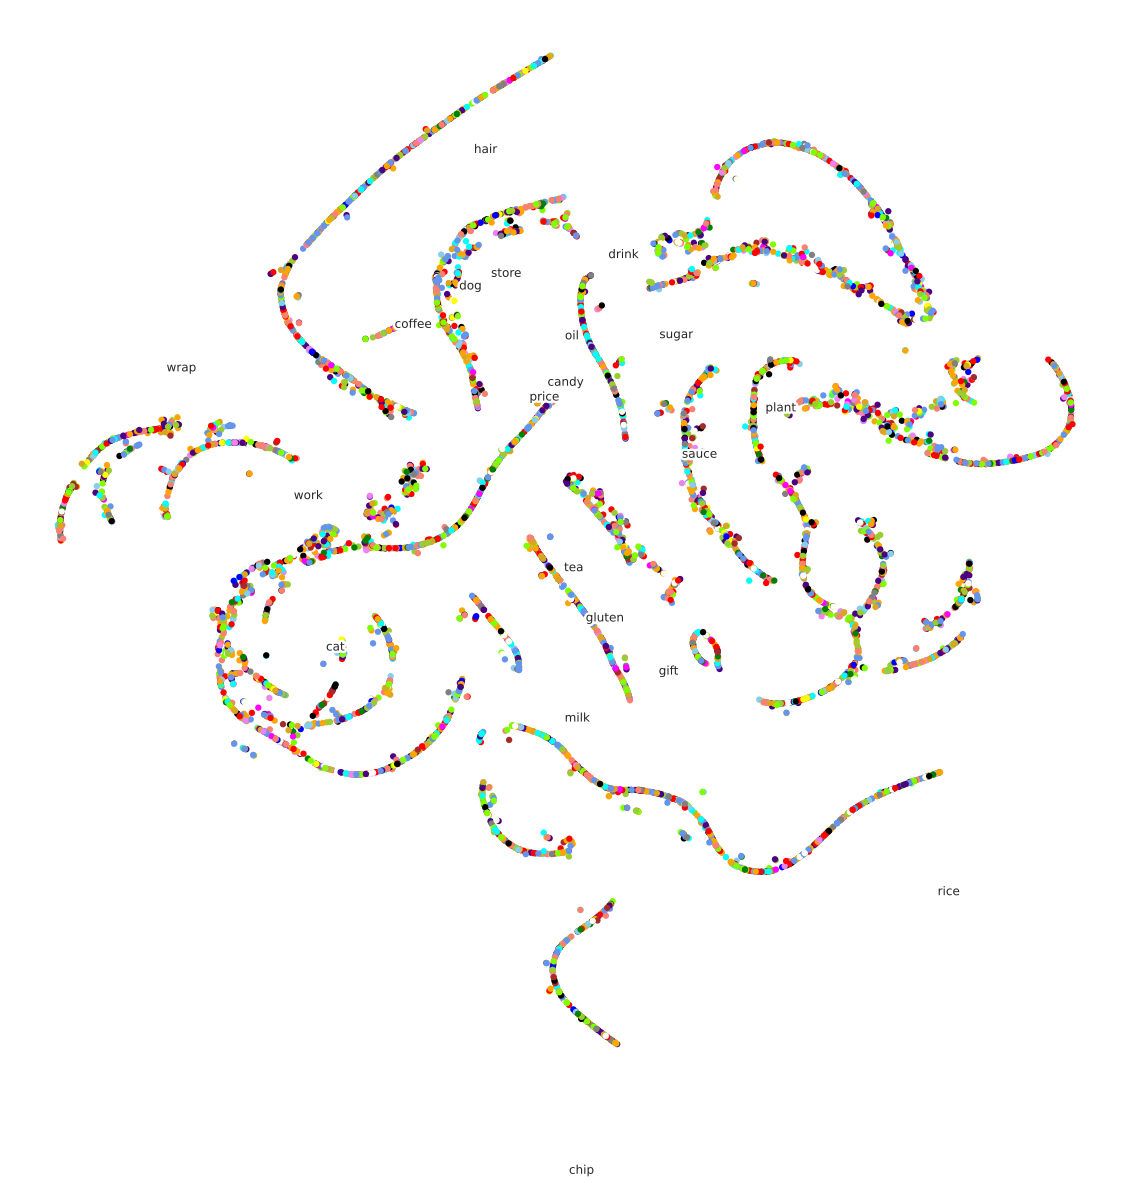

In [99]:
gen_tSNE_plot(docReducedTopicMatrix_tSNE_GR_sub, wordTopicmatrixGR_df, Y,10,10)

**TODO**
You ran the cluster on the whole set of bad reviews. Include that here and add some narration to it.

#### Bad Reviews
Now let's check the quality of results of the topic generation by finding the reviews that scored best in the `docTopicMatrixBR_df`

##### Eye-Ball Checking Text

In [104]:
docTopicMatrixBR = LD_AllocatorTFIDFBR.transform(docTermMatrixTFIDFBR)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
docTopicMatrixBR_df = pd.DataFrame(docTopicMatrixBR).add_prefix("topic_")
docTopicMatrixBR_df[["Summary","ProcessedText","Text","Score"]] = bad_reviews_df[["Summary","ProcessedText","Text","Score"]]
docTopicMatrixBR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Summary,ProcessedText,Text,Score
0,0.010744,0.010744,0.795871,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,...,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,Cough Medicine,if you be look for the secret ingredient in i ...,If you are looking for the secret ingredient i...,2
1,0.010138,0.010138,0.010138,0.075417,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,...,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,My Cats Are Not Fans of the New Food,my have be happily eat platinum for more than ...,My cats have been happily eating Felidae Plati...,1
2,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,...,0.014124,0.014124,0.014124,0.014124,0.731646,0.014124,Nasty No flavor,the candy be just red no flavor just plan and ...,"The candy is just red , No flavor . Just plan...",1
3,0.014473,0.014473,0.725015,0.014473,0.014473,0.014473,0.014473,0.014473,0.014473,0.014473,...,0.014473,0.014473,0.014473,0.014473,0.014473,0.014473,Don't like it,this oatmeal be not good it mushy soft i like ...,"This oatmeal is not good. Its mushy, soft, I d...",1
4,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,...,0.018488,0.018488,0.018488,0.018488,0.648735,0.018488,stale product.,in day and be so stale i could not eat any of the,Arrived in 6 days and were so stale i could no...,1


Picked a topic. Read three or more reviews. If the reviews all appear to be about the same theme, then you can say that the topic was synthesized well by LDA.

In [ ]:
#find 5 reviews that score highest in topic_X
for review in docTopicMatrixBR_df.sort_values(by="topic_15",ascending=False).head(1)[["Summary","Score","Text"]].values:
    print(review,"\n")

These all appear to be about coffee. So LDA did well in creating this topic and assigning this topic as the largest vector component in the document-topic matrix for these reviews.

In [107]:
bad_review_vocab = tfidfvectorizer_br.get_feature_names()
wordTopicmatrixBR_df = pd.DataFrame(LD_AllocatorTFIDFBR.components_,columns=bad_review_vocab).T.add_prefix("topic_")
#wordTopicmatrixBR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
#(wordTopicmatrixBR_df.sort_values(by="topic_12",ascending=False).head(5))["topic_12"]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Cluster Plot

In [ ]:
pcaBR = PCA(n_components=2)
pcaBR.fit(docTopicMatrixBR)
docReducedTopicMatrixBR = pcaBR.transform(docTopicMatrixBR)


In [110]:
review_subset_size = 7000

numb_of_bad_reviews = docReducedTopicMatrixBR.shape[0]
selected_reviews = np.random.choice(numb_of_bad_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixBR_sub = docReducedTopicMatrixBR[selected_reviews,:]


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time spent doing operation is 0:02:23.117055


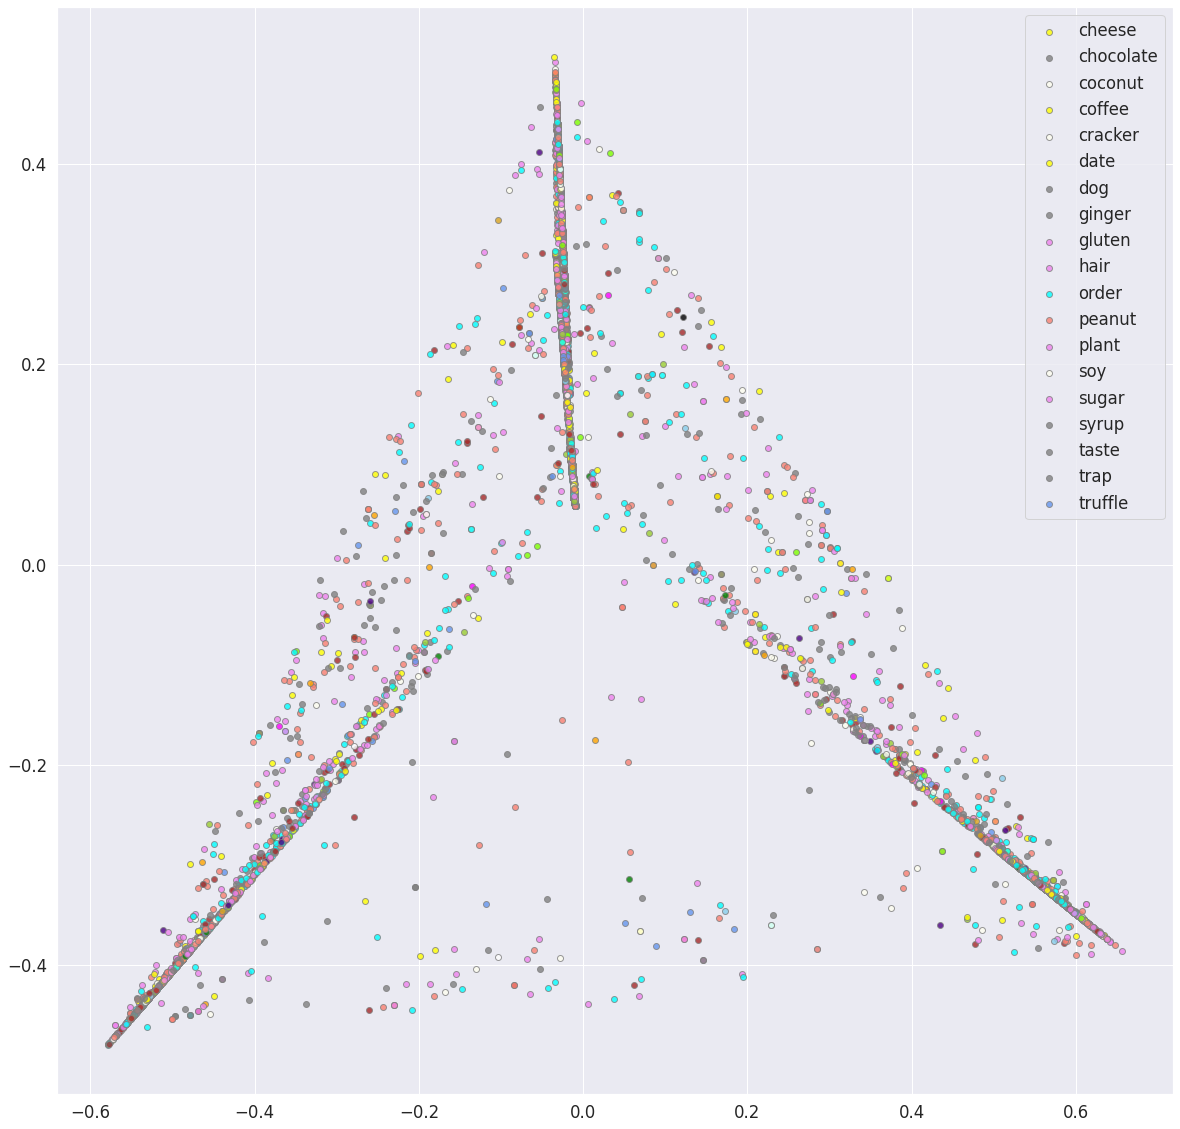

In [111]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()
plot_PCA_2D2(docReducedTopicMatrixBR_sub, docTopicMatrixBR_df,wordTopicmatrixBR_df,"bad_reviews_subset.png")
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

This is a plot of 7000 (or whatever `review_subset_size`  is set to ) bad review documents. The (x,y) coordinates for each dot (document) comes from `docReducedTopicMatrixBR_sub` which is `docTopicMatrixBR` PCA reduced from 20 to 2 components.
To interpret this requires analyzing the internal data members of the PCA object.

Here it is:

```
array([[-7.98973409e-04, -4.84492470e-04, -6.30803307e-03,
        -5.77547777e-04, -5.45425595e-04, -2.52963937e-03,
        -6.55100988e-01, -2.97883195e-02, -8.77808087e-03,
        -2.57277093e-03, -2.82886052e-02, -3.43547123e-03,
        -8.30482723e-04, -3.44433278e-03,  2.33281643e-04,
         7.54288740e-01, -1.55961972e-03, -1.81480336e-03,
        -6.35491221e-03, -1.30952312e-03],
       [ 2.89561510e-03,  1.04108701e-02,  7.18506568e-02,
         7.76265567e-03,  3.91825487e-03,  1.05306291e-02,
        -6.16792475e-01,  5.18385179e-01,  6.77127591e-02,
         6.81458909e-03,  2.90346236e-01,  1.69660566e-02,
         7.41471331e-03,  1.29623951e-02,  3.07430298e-03,
        -5.02171102e-01,  4.75301049e-03,  2.48609820e-02,
         5.56963561e-02,  2.60831574e-03]])

```

Looks like PCA component 0 is dominated by `topic_15` which is "coffee". And PCA component 1 is dominated by `topic_7` which is "drink"

##### tSNE Plot

In [112]:
#getcolor(row_index,basecolor,doc_topic_matrix_df)

Y = [ getcolor(row_index,"#000000",docTopicMatrixBR_df) for row_index in range(docReducedTopicMatrixBR_sub.shape[0])]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [ ]:
docReducedTopicMatrix_tSNE_BR_sub = TSNE(random_state=RANDOM_STATE).fit_transform(docReducedTopicMatrixBR_sub)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
gen_tSNE_plot(docReducedTopicMatrix_tSNE_BR_sub, wordTopicmatrixBR_df, Y,10,10)

**Caution**: Running the two cells below can take up to 12 hours to run. I'm protecting them with a option variable below.

In [ ]:
if GENERATE_FULL_SCATTER_PLOT:
    start_time = datetime.datetime.now()
    plot_PCA_2D2(docReducedTopicMatrixBR, docTopicMatrixBR_df,"bad_reviews_full.png")
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))

In [ ]:
if GENERATE_FULL_SCATTER_PLOT:

    start_time = datetime.datetime.now()
    plot_PCA_2D2(docReducedTopicMatrixGR, docTopicMatrixGR_df,"good_reviews_full.png")
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))

# Component Selection Evaluation
In this section I will perform KMeans clustering of the good and bad reviews and generate a [scree plot](https://en.wikipedia.org/wiki/Scree_plot). The purpose of the scree plotting will be to determine if the number of topics chosen in the PCA analysis performed above explains an adequate amount of variance in the respective reviews.

### Good Review Scree Plot Analysis

In [ ]:
docTermMatrixTFIDFBR.shape

In [ ]:
#Using the TFIDF vectorized document term matrix as the data set
pcaGR40 = TruncatedSVD(n_components=40)
pcaGR40.fit(docTermMatrixTFIDFGR)
plt.figure(figsize=(20,20))
plt.plot(pcaGR40.explained_variance_ratio_)
plt.xlabel("Topic Number",fontsize=16)
plt.ylabel("Percent Explained Variance",fontsize=16)
plt.show();

The scree plot indicates that most of the variance can be explained with 5 topics. I selected 20 topics, so this plot indicates that I'm explaining sufficient amount of variance.

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

In [ ]:
#plt.figure(figsize=(20,20))
#plt.plot(np.cumsum(pcaGR40.explained_variance_ratio_))
#plt.xlabel("Number of Topics",fontsize=16)
#plt.ylabel("Cumulative Percent of Explained Variance",fontsize=16)
#plt.show();

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

### Bad Review Scree Plot Analysis

In [ ]:
#Using the TFIDF vectorized document term matrix as the data set
pcaBR40 = TruncatedSVD(n_components=40)
pcaBR40.fit(docTermMatrixTFIDFBR)
plt.figure(figsize=(20,20))
plt.plot(pcaBR40.explained_variance_ratio_)
plt.xlabel("Topic Number",fontsize=16)
plt.ylabel("Explained Variance",fontsize=16)
plt.show();

The scree plot indicates that most of the variance can be explained with 5 topics. I selected 20 topics, so this plot indicates that I'm explaining sufficient amount of variance.

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

In [ ]:
#plt.figure(figsize=(20,20))
#plt.plot(np.cumsum(pcaBR40.explained_variance_ratio_))
#plt.xlabel("Number of Topics",fontsize=16)
#plt.ylabel("Percent of Explained Variance",fontsize=16)
#plt.show();

# Conclusion

We can use this notebook to compare / contrast good vs bad reviews on the same topic to more quickly determine what could be right or wrong about the products described within said reviews.

Example here are 3 good and bad reviews on the "coffee" topic:


In [ ]:
for review in docTopicMatrixGR_df.sort_values(by="topic_15",ascending=False).head(1)[["Summary","Score","Text"]].values:
    print(review,"\n")

In [ ]:
for review in docTopicMatrixBR_df.sort_values(by="topic_15",ascending=False).head(1)[["Summary","Score","Text"]].values:
    print(review,"\n")

As you can see, people who like coffee like it because it's "aromatic","nice", and "bold". People dislike their coffee because it's "metallic","sour" and "taste like you just drank contents of an ashtray." This took very little time to ascertain compared to having to (1) search for reviews on the topic of coffee, and then (2) find a positive review about coffee and a negative review about coffee.